In [1]:
import random
import geopandas as gpd
import googlemaps
import keyring
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import matplotlib as mpl
import mplleaflet
import pandas as pd
import numpy as np
import calendar
import polyline
import seaborn as sns
from datetime import datetime
from IPython.display import Markdown
from pyspark.sql import SparkSession
from pyspark.sql.functions import udf
from pyspark.sql.types import *
from shapely.geometry import Point, LineString

palette = sns.color_palette("colorblind", 20)


def to_geo(df, x_field='longitude', y_field='latitude'):
    geometry = [Point(xy) for xy in zip(df[x_field], df[y_field])]
    return gpd.GeoDataFrame(df, geometry=geometry)


spark = (
    SparkSession.builder
        .master("local")
        .appName("TFL Notebook")
        .config('spark.executor.memory', '8G')
        .config('spark.driver.memory', '16G')
        .config('spark.driver.maxResultSize', '10G')
        .config("spark.sql.crossJoin.enabled", "true")
        .getOrCreate()
)

trips = spark.read.parquet("../data/parquet_trip")
trips.createOrReplaceTempView("trips")

df = spark.sql("""
    select 
      count(distinct(bike_id)) as bike_count, 
      count(1) as trip_count, 
      start_year, 
      start_month,
      start_year || '-' || start_month as month
    from trips
    group by start_year, start_month
    order by start_year asc, start_month asc
""")

def month_label(year, month):
    return "{0} {1}".format(calendar.month_name[int(month)], year)

month_label_udf = udf(month_label, StringType())
df = df.withColumn("month_label", month_label_udf("start_year", "start_month"))

df.createOrReplaceTempView("monthly_counts")

monthly_counts = df.toPandas()

monthly_counts

,bike_count,trip_count,start_year,start_month,month,month_label
0,11319,546113,2015,1,2015-1,January 2015
1,11284,542526,2015,2,2015-2,February 2015
2,11348,694364,2015,3,2015-3,March 2015
3,11391,829921,2015,4,2015-4,April 2015
4,11327,892692,2015,5,2015-5,May 2015
5,11217,1030640,2015,6,2015-6,June 2015
6,11294,1122670,2015,7,2015-7,July 2015
7,11198,1030760,2015,8,2015-8,August 2015
8,11153,894635,2015,9,2015-9,September 2015
9,11146,876245,2015,10,2015-10,October 2015


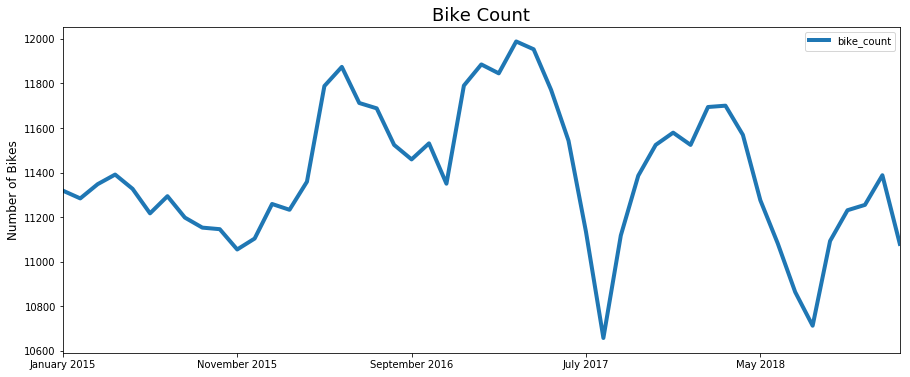

In [2]:
fig, ax = plt.subplots(figsize=(15, 6))

monthly_counts.plot(ax=ax, kind='line', x='month_label', y='bike_count', linewidth=4.0)

plt.title("Bike Count", fontsize=18)
plt.xlabel('')
plt.ylabel('Number of Bikes', fontsize=12)
plt.legend(loc='best')
plt.show()

In [3]:
3

3

## 